<a href="https://colab.research.google.com/github/Alirzeanoroozi/deep_learning_codes/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create Dataset


In [ ]:
import numpy as np
import random

np.random.seed(37)
random.seed(37)

size = 1_000

X_0 = np.random.normal(0, 1, size=size)
X_1 = 1.1 + 4 * X_0 + np.random.normal(0, 1, size=size)
X_2 = 2.3 - 0.5 * X_0 + np.random.normal(0, 1, size=size)

X = np.hstack([X_0.reshape(-1, 1), X_1.reshape(-1, 1), X_2.reshape(-1, 1)])

X.shape

(1000, 3)

In [ ]:
import itertools
import pandas as pd

def make_missing(X, frac=0.1):
    n = int(frac * X.shape[0] * X.shape[1])

    rows = list(range(X.shape[0]))
    cols = list(range(X.shape[1]))

    coordinates = list(itertools.product(*[rows, cols]))
    random.shuffle(coordinates)
    coordinates = coordinates[:n]

    M = np.copy(X)

    for r, c in coordinates:
        M[r, c] = np.nan

    return pd.DataFrame(M, columns=[f'X_{i}' for i in range(X.shape[1])]), coordinates

df, coordinates = make_missing(X)

In [ ]:
df.isna().sum()

X_0     99
X_1    102
X_2     99
dtype: int64

In [ ]:
N_df = df.dropna()
T_df = pd.DataFrame(X[df.isnull().any(axis=1), :], columns=N_df.columns)
M_df = df[df.isnull().any(axis=1)]

N_df.shape, T_df.shape, M_df.shape

((732, 3), (268, 3), (268, 3))

In [ ]:
print(N_df.iloc[0])
print(T_df.iloc[0])
print(M_df.iloc[0])

X_0    0.674308
X_1    3.724844
X_2    0.843894
Name: 1, dtype: float64
X_0   -0.054464
X_1    0.222191
X_2    2.381753
Name: 0, dtype: float64
X_0   -0.054464
X_1         NaN
X_2    2.381753
Name: 0, dtype: float64


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import *

class SampleDataset(Dataset):
    def __init__(self, X):
        self.__X = X

    def __len__(self):
        return self.__X.shape[0]

    def __getitem__(self, idx):
        return self.__X[idx,:]

N_ds = SampleDataset(N_df.values)
M_ds = SampleDataset(M_df.fillna(0.0).values)

N_dl = DataLoader(N_ds, batch_size=64, shuffle=True)
M_dl = DataLoader(M_ds, batch_size=64, shuffle=True)

In [ ]:
from torchvision import datasets
from torchvision import transforms

class AE(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.input_size = input_size
        self.drop_out = torch.nn.Dropout(p=0.5)

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, input_size)
        )

    def forward(self, x):
        drop_out = self.drop_out(x)
        encoded = self.encoder(drop_out)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
def train(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
    loss_function = torch.nn.MSELoss()

    epochs = 20
    loss_df = []

    for epoch in range(epochs):
        losses = []

        for items in N_dl:
            optimizer.zero_grad()

            reconstructed = model(items)
            loss = loss_function(reconstructed, items)

            loss.backward()
            optimizer.step()

            losses.append(loss.detach().cpu().numpy().item())

        loss_df.append(np.array(losses).mean())
    return loss_df

In [ ]:
model = AE(input_size=N_df.shape[1]).double()
loss = train(model)

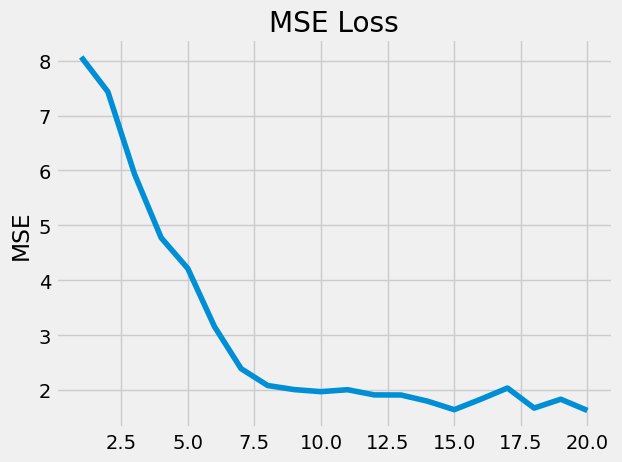

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(range(1, 21, 1)), loss)
plt.title('MSE Loss')
plt.ylabel('MSE')
plt.show()

In [ ]:
def get_imputation(m_v, p_v, t_v):
    return np.array([p if pd.isna(m) else t for m, p, t in zip(m_v, p_v, t_v)])

def get_performance(model):
    N_pred = np.vstack([model(items).cpu().detach().numpy() for items in N_dl])
    M_pred = np.vstack([model(items).cpu().detach().numpy() for items in M_dl])
    I_pred = np.array([get_imputation(M_df.values[r,:], M_pred[r,:], T_df.values[r,:]) for r in range(M_df.shape[0])])

    n_perf = np.array([np.linalg.norm(N_df.values[r,:] - N_pred[r,:], 2) for r in range(N_df.shape[0])]).mean()
    m_perf = np.array([np.linalg.norm(T_df.values[r,:] - I_pred[r,:], 2) for r in range(T_df.shape[0])]).mean()

    return n_perf, m_perf

In [ ]:
get_performance(model)

(4.592459849988189, 2.1270108576494335)